In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from torch.utils.data import DataLoader
from torchvision import transforms as T
from transformers import AutoImageProcessor, AutoModel

from oadino.clevr import load_clever_dataset

In [2]:
img_size = 224
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2_vits14 = dinov2_vits14.cuda()
dinov2_vits14.eval()
patch_h = patch_w = img_size // 14

Using cache found in /home/rya/.cache/torch/hub/facebookresearch_dinov2_main
/home/rya/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/rya/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/rya/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
# Load clevr data for visualization

transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize(img_size + int(img_size * 0.01) * 10),
        T.CenterCrop(img_size),
        T.Normalize([0.5], [0.5]),
    ]
)

_, _, val_dataset = load_clever_dataset(
    Path("/ssd2/mldata/CLEVR_v1.0/images"), maxsize=4096, transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=8)
batch_size=8

In [4]:
batch = next(iter(val_loader))
images = batch["image"]  # torch.Size([8, 3, 224, 224])

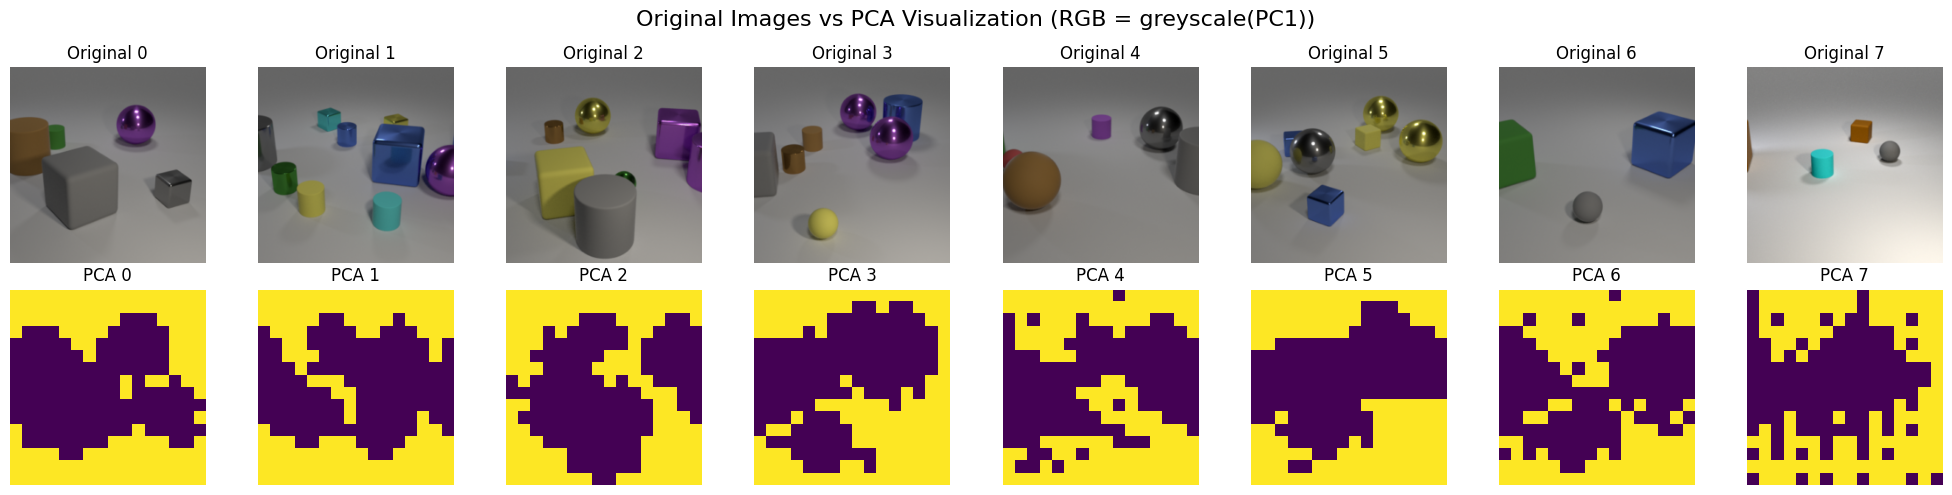

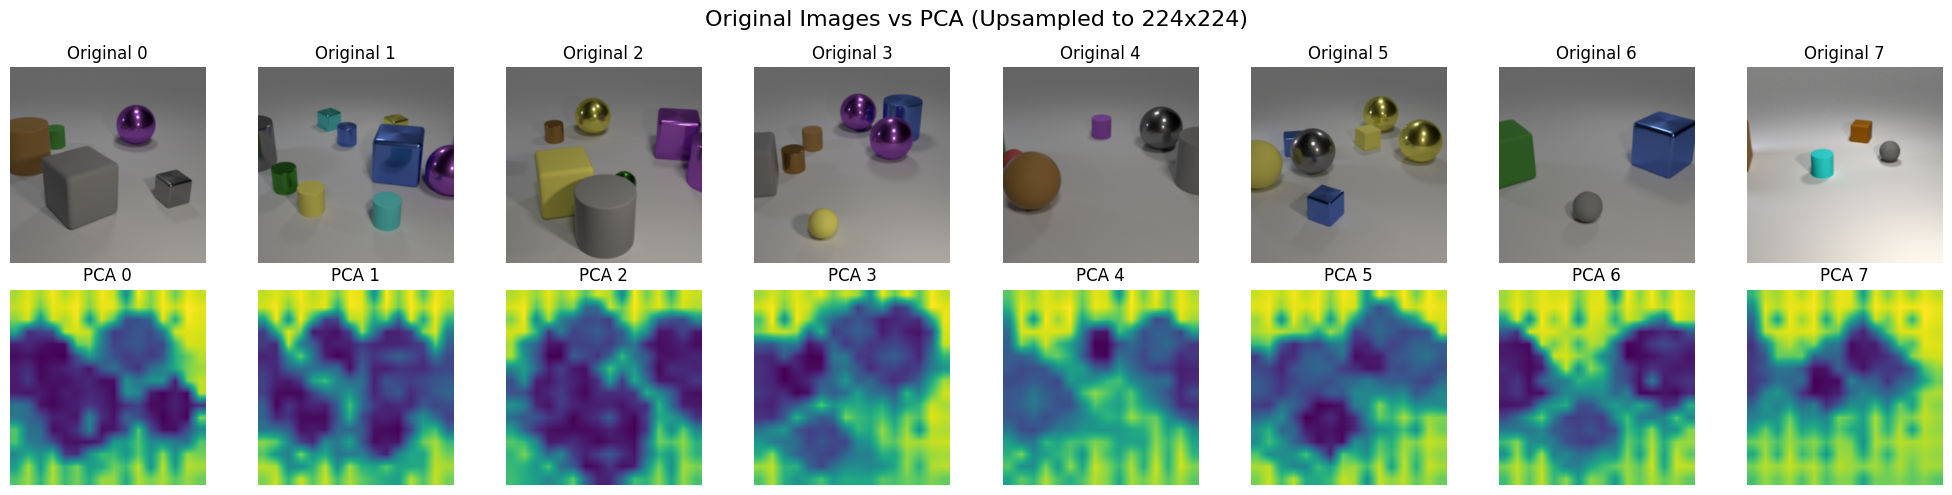

(16, 16)

In [5]:
# Process images through DINOv2
with torch.no_grad():
    embeddings = dinov2_vits14.forward_features(images.cuda())
    x_norm_patchtokens = embeddings["x_norm_patchtokens"].cpu().numpy()

    x_norm_1616_patches = x_norm_patchtokens.reshape(batch_size * patch_h * patch_w, -1)

    fg_pca = PCA(n_components=1)
    fg_pca_images = fg_pca.fit_transform(x_norm_1616_patches)
    fg_pca_images = minmax_scale(fg_pca_images)
    fg_pca_images = fg_pca_images.reshape(batch_size, patch_h, patch_w)


# Visualize results
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
# fig.suptitle('Original Images vs PCA Visualization (RGB = PC1, PC2, PC3)', fontsize=16)
fig.suptitle("Original Images vs PCA Visualization (RGB = greyscale(PC1))", fontsize=16)

for i in range(8):
    # Original image
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original {i}")

    # PCA visualization (16x16 will be upsampled by imshow)
    pca_img = fg_pca_images[i]
    pca_img = pca_img > np.median(pca_img)
    pca_img = pca_img.astype(np.float32)
    axes[1, i].imshow(pca_img, interpolation="nearest")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"PCA {i}")

plt.tight_layout()
plt.show()

# Optional: Show higher resolution PCA by upsampling to match original image size
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle("Original Images vs PCA (Upsampled to 224x224)", fontsize=16)

for i in range(8):
    # Original image
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original {i}")

    # PCA visualization upsampled
    pca_img = fg_pca_images[i]
    axes[1, i].imshow(pca_img, interpolation="bilinear")  # Smooth upsampling
    axes[1, i].axis("off")
    axes[1, i].set_title(f"PCA {i}")

plt.tight_layout()
plt.show()
fg_pca_images[i].shape

In [6]:
embeddings

{'x_norm_clstoken': tensor([[-3.4354e+00, -7.1056e-01,  1.7666e+00,  ..., -5.9150e-01,
           5.5280e-01, -1.0625e+00],
         [-2.4245e+00, -7.3214e-01, -8.1924e-01,  ...,  5.8120e-01,
           7.3306e-01,  1.9810e-01],
         [-3.8471e+00, -1.2393e+00,  1.3831e+00,  ...,  9.2809e-01,
           1.6294e+00, -3.5494e-01],
         ...,
         [-1.9378e+00, -3.4749e-02,  1.7666e+00,  ..., -2.6793e+00,
          -3.3356e-01, -1.6193e+00],
         [-2.2484e+00, -1.7345e+00, -1.1423e+00,  ...,  1.1794e+00,
           6.8230e-02,  1.0304e-03],
         [-2.6949e+00, -1.5291e+00, -8.0781e-01,  ...,  9.9828e-01,
          -1.6010e+00,  1.2760e+00]], device='cuda:0'),
 'x_norm_regtokens': tensor([], device='cuda:0', size=(8, 0, 384)),
 'x_norm_patchtokens': tensor([[[-3.8295e+00, -5.1213e+00, -1.3568e+00,  ..., -1.2905e+00,
            1.0405e+00,  5.5851e-01],
          [-3.3479e+00, -3.6873e+00, -6.4260e-01,  ..., -2.1599e+00,
            2.0975e-01,  2.2087e+00],
          [-2.

In [7]:
from typing import Sequence

import torch
from torch import nn
from torchvision import transforms
from transformers import PreTrainedModel


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

    def encode(self, x):
        raise NotImplementedError

    def decode(self, z):
        raise NotImplementedError

    def reparametrization(self, mean, var):
        raise NotImplementedError

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


class ConvVAE16(VAE):
    """Variationnal autoencoders encoding dino patches (14*14 a priori)
    The paper uses 64*64 patches resized from 14*14 but not sure why they do it
    This Small 16*16 VAE is used instead for faster testing
    """

    def __init__(self, latent_base=64, prior_dim=32):
        """Latent dim will be latent_base*16"""
        super().__init__()

        self.input_size = 16
        self.latent_base = latent_base
        self.latent_dim = latent_base * 16
        self.prior_dim = prior_dim

        # Encoder: 16x16 -> 8x8 -> 4x4 -> 2x2 -> flatten
        self.encoder = nn.Sequential(
            # Input: (batch, 3, 16, 16)
            nn.Conv2d(
                3, latent_base, kernel_size=3, stride=2, padding=1
            ),  # -> (batch, lb, 8, 8)
            nn.BatchNorm2d(latent_base),
            nn.ReLU(),
            nn.Conv2d(
                latent_base, latent_base * 2, kernel_size=3, stride=2, padding=1
            ),  # -> (batch, 2lb, 4, 4)
            nn.BatchNorm2d(latent_base * 2),
            nn.ReLU(),
            nn.Conv2d(
                latent_base * 2, latent_base * 4, kernel_size=3, stride=2, padding=1
            ),  # -> (batch, 4lb, 2, 2)
            nn.BatchNorm2d(latent_base * 4),
            nn.ReLU(),
            nn.Flatten(),  # -> (batch, 4lb*2*2 = 16lb)
        )

        # Mean and logvar layers for latent space
        self.mean_layer = nn.Sequential(nn.Linear(latent_base * 4 * 2 * 2, prior_dim))
        self.logvar_layer = nn.Sequential(nn.Linear(latent_base * 4 * 2 * 2, prior_dim))

        # Decoder: latent -> 2x2 -> 4x4 -> 8x8 -> 16x16
        self.decoder = nn.Sequential(
            nn.Linear(prior_dim, 16 * latent_base),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (latent_base * 4, 2, 2)),  # -> (batch, 4lb, 2, 2)
            nn.ConvTranspose2d(
                latent_base * 4, latent_base * 2, kernel_size=4, stride=2, padding=1
            ),  # -> (batch, 2lb, 4, 4)
            nn.BatchNorm2d(latent_base * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                latent_base * 2, latent_base, kernel_size=4, stride=2, padding=1
            ),  # -> (batch, lb, 8, 8)
            nn.BatchNorm2d(latent_base),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                latent_base, 3, kernel_size=4, stride=2, padding=1
            ),  # -> (batch, 3, 16, 16)
            nn.Sigmoid(),  # Output in [0, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = self.mean_layer(h), self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(var.device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


class ConvVAE64(VAE):
    """Variationnal autoencoders encoding dino patches (14*14 a priori)
    The paper uses 64*64 patches resized from 14*14 but not sure why they do it
    """

    def __init__(self, latent_base=32, prior_dim=32):
        """Latent dim will be latent_base*32"""
        super().__init__()

        self.input_size = 64
        self.latent_base = latent_base
        self.latent_dim = latent_base * 32
        self.prior_dim = prior_dim

        # Encoder: 64x64 -> 31x31 -> 14x14 -> 6x6 -> 2x2 -> flatten
        self.encoder = nn.Sequential(
            # Input: (batch, 3, 64, 64)
            nn.Conv2d(
                3, latent_base, kernel_size=4, stride=2, padding=0
            ),  # -> (batch, lb, 31, 31)
            nn.ReLU(),
            nn.Conv2d(
                latent_base, latent_base * 2, kernel_size=4, stride=2, padding=0
            ),  # -> (batch, 2lb, 14, 14)
            nn.ReLU(),
            nn.Conv2d(
                latent_base * 2, latent_base * 4, kernel_size=4, stride=2, padding=0
            ),  # -> (batch, 4lb, 6, 6)
            nn.ReLU(),
            nn.Conv2d(
                latent_base * 4, latent_base * 8, kernel_size=4, stride=2, padding=0
            ),  # -> (batch, 8lb, 2, 2)
            nn.ReLU(),
            nn.Flatten(),  # -> (batch, 8lb*4*4)
        )

        # Mean and logvar layers for latent space
        self.mean_layer = nn.Sequential(nn.Linear(latent_base * 8 * 2 * 2, prior_dim))
        self.logvar_layer = nn.Sequential(nn.Linear(latent_base * 8 * 2 * 2, prior_dim))

        # Decoder: latent -> 2x2 -> 6x6 -> 14x14 -> 31x31 -> 64x64
        self.decoder = nn.Sequential(
            nn.Linear(prior_dim, latent_base * 8 * 2 * 2),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (latent_base * 8, 2, 2)),
            nn.ConvTranspose2d(
                latent_base * 8, latent_base * 4, kernel_size=4, stride=2, padding=0
            ),  # -> (batch, 4lb, 6, 6)
            nn.ReLU(),
            nn.ConvTranspose2d(
                latent_base * 4, latent_base * 2, kernel_size=4, stride=2, padding=0
            ),  # -> (batch, 2lb, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(
                latent_base * 2, latent_base, kernel_size=4, stride=2, padding=0
            ),  # -> (batch, 1lb, 31, 31)
            nn.ReLU(),
            nn.ConvTranspose2d(
                latent_base, 3, kernel_size=4, stride=2, padding=0
            ),  # -> (batch, 1lb, 64, 64)
            nn.Sigmoid(),  # Output in [0, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mean, logvar = self.mean_layer(h), self.logvar_layer(h)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(var.device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


class OADinoPreProcessor(nn.Module):
    def __init__(self, backbone: nn.Module):
        """The Processor now expects the backbone to be a model loaded from torch.hub
        For example:
            dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
        """
        super().__init__()
        self.backbone = backbone

    @staticmethod
    def get_median_mask(flat_patches, pca_q=None, pca_niter=2):
        device = flat_patches.device
        fg_pca = PCA(n_components=1)
        patch_pca = fg_pca.fit_transform(flat_patches.detach().cpu())
        mask = patch_pca > np.median(patch_pca)
        mask = torch.from_numpy(mask)
        return ~mask.to(device).squeeze(-1)

    @staticmethod
    def get_mean_mask(flat_patches, pca_q=None, pca_niter=2):
        flattened_patches_centered = flat_patches - flat_patches.mean(dim=0)
        U, S, V = torch.pca_lowrank(flattened_patches_centered, pca_q, False, pca_niter)
        patch_pca = torch.matmul(flattened_patches_centered, V[:, 0])
        return patch_pca > patch_pca.mean()

    def segment_images(self, images, pca_q=None, pca_niter=2, add_opt_outputs=False):
        """Segment images to isolate objects based on pca and DINOV2 features
        images are expected to come in batches of shape (batch_size, 3, 224, 224)
        images are expected to be scaled in 0, 1 then normalized with a transform like
        T.Normalize([0.5], [0.5])
        """
        with torch.no_grad():
            outputs = self.backbone.forward_features(images)

            # (batch_size, 1+n_patches, hidden_size)
            backbone_patches = outputs["x_norm_patchtokens"]

            batch_size, n_patches, hidden_size = backbone_patches.shape
            _, _, height, width = images.shape
            patch_size = 14  # DINOv2 patch size 14

            # 1. Foreground separation of patches

            flattened_patches = backbone_patches.reshape((-1, hidden_size))
            rough_mask = self.get_median_mask(flattened_patches, pca_q, pca_niter)
            # 2. Refining object consistency

            masked_patches = flattened_patches[rough_mask]
            refined_mask = self.get_median_mask(masked_patches, pca_q, pca_niter)
            # refined_mask = self.get_mean_mask(masked_patches, pca_q, pca_niter)

            # 3. Remapping to image space

            mask = rough_mask.clone()
            mask[rough_mask] = refined_mask

            pixel_mask = mask.reshape(
                (batch_size, 1, height // patch_size, 1, width // patch_size, 1)
            )
            pixel_mask = pixel_mask.expand((-1, 3, -1, patch_size, -1, patch_size))
            pixel_mask = pixel_mask.reshape((batch_size, 3, height, width))
            pixel_mask = pixel_mask.float()
            pixel_mask = 1 - pixel_mask # true means masked, but true is 1. and we want 0. to mask
            segmented_images = -1*pixel_mask + images*(1-pixel_mask)

            if add_opt_outputs:
                return segmented_images, mask.reshape(batch_size, n_patches), backbone_patches, rough_mask.reshape(batch_size, n_patches)
            else:
                return segmented_images, mask.reshape(batch_size, n_patches)

    def create_patches(self, images):
        # sizes listed in the paper are 518 and 14
        # in practice not sure this is actually the case ?
        batch_size, channels, height, width = images.shape

        patch_size = 14  # DINOv2 patch size 14

        # Calculate number of patches
        num_patches_h = height // patch_size  # 518 // 14 = 37
        num_patches_w = width // patch_size  # 518 // 14 = 37

        # Reshape to extract patches
        # (batch, 3, 224, 224) -> (batch, 3, 37, 14, 37, 14)
        patches = images.reshape(
            batch_size, channels, num_patches_h, patch_size, num_patches_w, patch_size
        )

        # Rearrange dimensions: (batch, 3, 37, 14, 37, 14) -> (batch, 37, 37, 3, 14, 14)
        patches = patches.permute(0, 2, 4, 1, 3, 5)

        # Flatten patches: (batch, 37, 37, 3, 14, 14) -> (batch, 37*37, 3, 14, 14)
        patches = patches.reshape(
            batch_size, num_patches_h * num_patches_w, 3, patch_size, patch_size
        )

        return patches

    def get_global_features_and_patches(self, images, pca_q=None, pca_niter=2):
        """Create global features, divide image into patches, and mask non object related patches
        returns:
        global_features:    (batch_size, feature_size_backbone)
        object_patches:     (batch_size, n_patches, n_channels, patch_size, patch_size)
        mask:               (batch_size, n_patches)
        """
        segmented_images, mask = self.segment_images(images, pca_q, pca_niter)
        object_patches = self.create_patches(segmented_images)
        global_features = self.backbone.forward_features(segmented_images)["x_norm_clstoken"]

        return global_features, object_patches, mask


# First implementation of the Oh-A-Dino model
# The idea is to, during training:
# - call segment_image to get segmented inputs for the rest of the model and the mask
# - call create_patches to create a set of patches
# - call encode_decode_patches to get the latent and reconstructed patches
# - compute the paper's vae encoder loss and backprop
class OADinoModel(nn.Module):
    def __init__(self, vae: VAE):
        super().__init__()
        self.vae = vae
        self.transform = transforms.Resize(self.vae.input_size)

    def get_features(
        self, global_features, object_patches, mask
    ) -> Sequence[torch.tensor]:
        """Create OADino features from global_features (dino on masked input) and patches
        Notes:
        - Some reviews mention using other segmentation methods (like using UNets), we could add implementations ?
        """
        masked_object_patches = object_patches[mask]
        masked_object_patches = self.transform(masked_object_patches)
        object_features, _ = self.vae.encode(masked_object_patches)

        oadino_features = []
        feature_idx = 0  # Track position in flattened object_features

        for idx in range(mask.shape[0]):
            # Count non-masked patches for this batch element
            n_not_masked = mask[idx].sum().item()

            if n_not_masked > 0:
                # Get global feature for this batch element: shape (ng,)
                global_feature = global_features[idx]  # shape: (ng,)

                # Get corresponding local features: shape (n_not_masked, nl)
                local_features = object_features[
                    feature_idx : feature_idx + n_not_masked
                ]  # shape: (n_not_masked, nl)

                # Expand global feature to match: shape (n_not_masked, ng)
                global_expanded = global_feature.unsqueeze(0).expand(n_not_masked, -1)

                # Concatenate: shape (n_not_masked, ng+nl)
                combined = torch.cat([global_expanded, local_features], dim=-1)

                oadino_features.append(combined)
                feature_idx += n_not_masked
            else:
                # No non-masked patches for this batch element
                # Return empty tensor with correct shape (0, ng+nl)
                empty = torch.empty(
                    0,
                    global_features.shape[1] + object_features.shape[1],
                    device=global_features.device,
                    dtype=global_features.dtype,
                )
                oadino_features.append(empty)

        return oadino_features

    def encode_decode_object_patches(self, object_patches, mask):
        """Take object_patches and a mask and return"""
        masked_object_patches = object_patches[mask]
        masked_object_patches = self.transform(masked_object_patches)
        return self.vae(masked_object_patches)


In [8]:
# Load a pretrained VAE checkpoint

checkpoint_path = Path(
    "runs/CLEVR_train_4K_224_20260202_210355/checkpoints/best_model.pt"
)
checkpoint = torch.load(checkpoint_path)
state_dict = checkpoint["model_state_dict"]

model = OADinoModel(ConvVAE16())
# model = OADinoModel(ConvVAE64)

model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
pre_processor = OADinoPreProcessor(dinov2_vits14)

# Visualizing PCA applied to images passed through DINO

In [10]:
it = iter(val_loader)

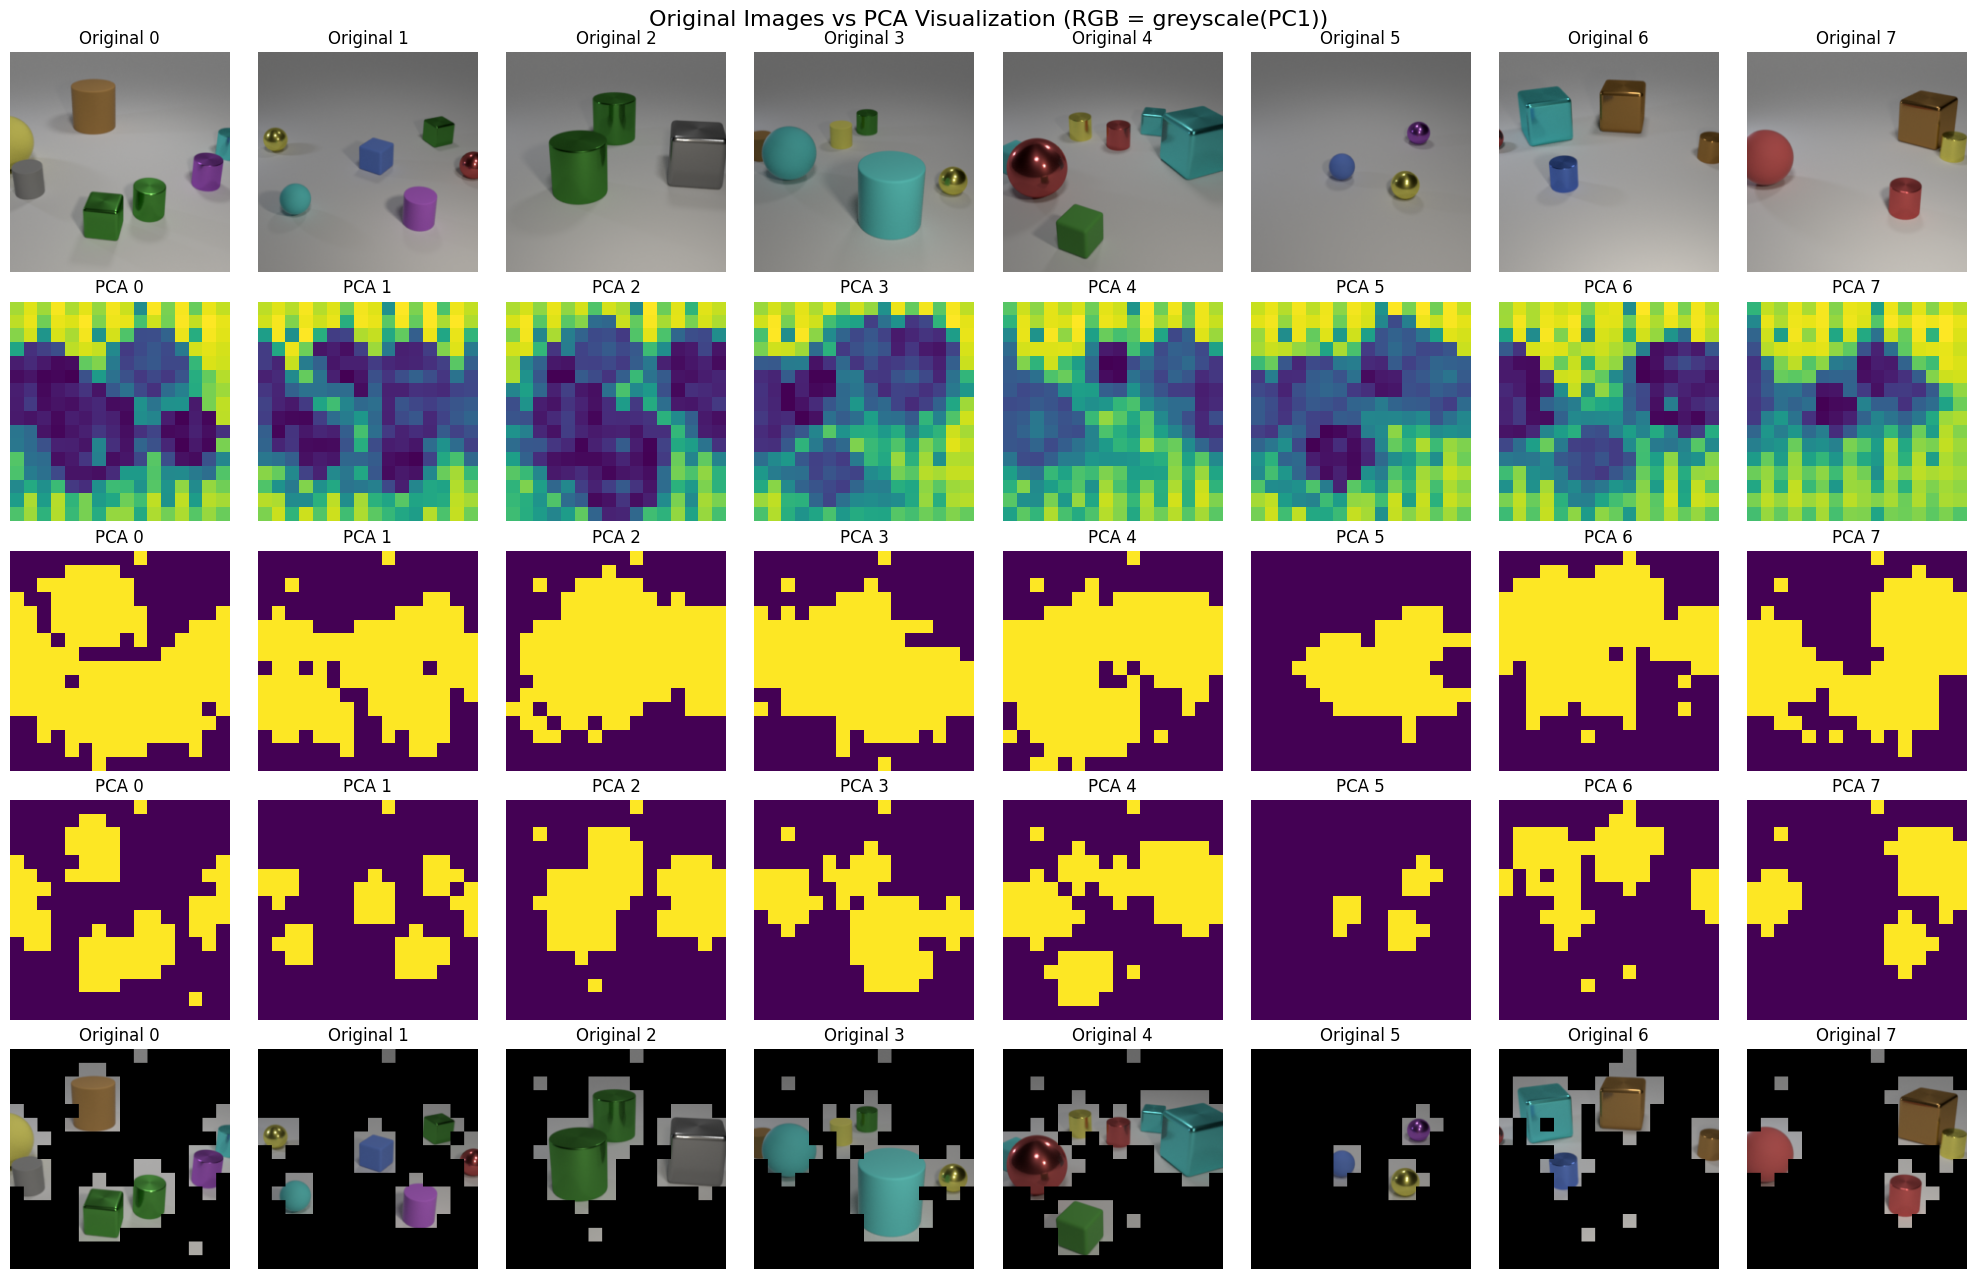

In [18]:
batch = next(it)
images = batch["image"]  # torch.Size([8, 3, 224, 224])

segmented_images, mask, backbone_patches, rough_mask = pre_processor.segment_images(images.cuda(), add_opt_outputs=True)

mask = mask.reshape((8, 1, 16, 16))
rough_mask = rough_mask.reshape((8, 1, 16, 16))
backbone_patches = backbone_patches.reshape((8, 16, 16, 384))
backbone_patches = backbone_patches.reshape(batch_size * patch_h * patch_w, -1)
fg_pca = PCA(n_components=1)
fg_pca_images = fg_pca.fit_transform(x_norm_1616_patches)
fg_pca_images = minmax_scale(fg_pca_images)
fg_pca_images = fg_pca_images.reshape(batch_size, patch_h, patch_w, 1)

# Visualize results
fig, axes = plt.subplots(5, 8, figsize=(20, 13))
# fig.suptitle('Original Images vs PCA Visualization (RGB = PC1, PC2, PC3)', fontsize=16)
fig.suptitle("Original Images vs PCA Visualization (RGB = greyscale(PC1))", fontsize=16)

for i in range(8):
    # Original image
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Original {i}")

    # PCA visualization (16x16 will be upsampled by imshow)
    pca_img = fg_pca_images[i]
    axes[1, i].imshow(pca_img, interpolation="nearest")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"PCA {i}")

    # rough mask visualization (16x16 will be upsampled by imshow)
    rough_mask_img = rough_mask[i].float().cpu().permute(1, 2, 0).numpy()
    axes[2, i].imshow(rough_mask_img, interpolation="nearest")
    axes[2, i].axis("off")
    axes[2, i].set_title(f"PCA {i}")

    # mask visualization (16x16 will be upsampled by imshow)
    mask_img = mask[i].float().cpu().permute(1, 2, 0).numpy()
    axes[3, i].imshow(mask_img, interpolation="nearest")
    axes[3, i].axis("off")
    axes[3, i].set_title(f"PCA {i}")

    # final segmented image visualization
    segmented_img = segmented_images[i].cpu().permute(1, 2, 0).numpy()
    segmented_img = (segmented_img - segmented_img.min()) / (segmented_img.max() - segmented_img.min() + 1e-8)
    axes[4, i].imshow(segmented_img)
    axes[4, i].axis("off")
    axes[4, i].set_title(f"Original {i}")

plt.tight_layout()
plt.show()

In [19]:
global_features, object_patches, mask = pre_processor.get_global_features_and_patches(
    images.cuda()
)

print(f"{global_features.shape=}")  # global_features.shape=torch.Size([8, 768])
print(
    f"{object_patches.shape=}"
)  # object_patches.shape=torch.Size([8, 256, 3, 14, 14])
print(f"{mask.shape=}")  # mask.shape=torch.Size([8, 256])

# TODO
# Show the first image in the path in a plot
# Show the resulting object patches that aren't masked by the given binary mask for the first image in the batch
# Not all but some of them [around 8 ?]

global_features.shape=torch.Size([8, 384])
object_patches.shape=torch.Size([8, 256, 3, 14, 14])
mask.shape=torch.Size([8, 256])


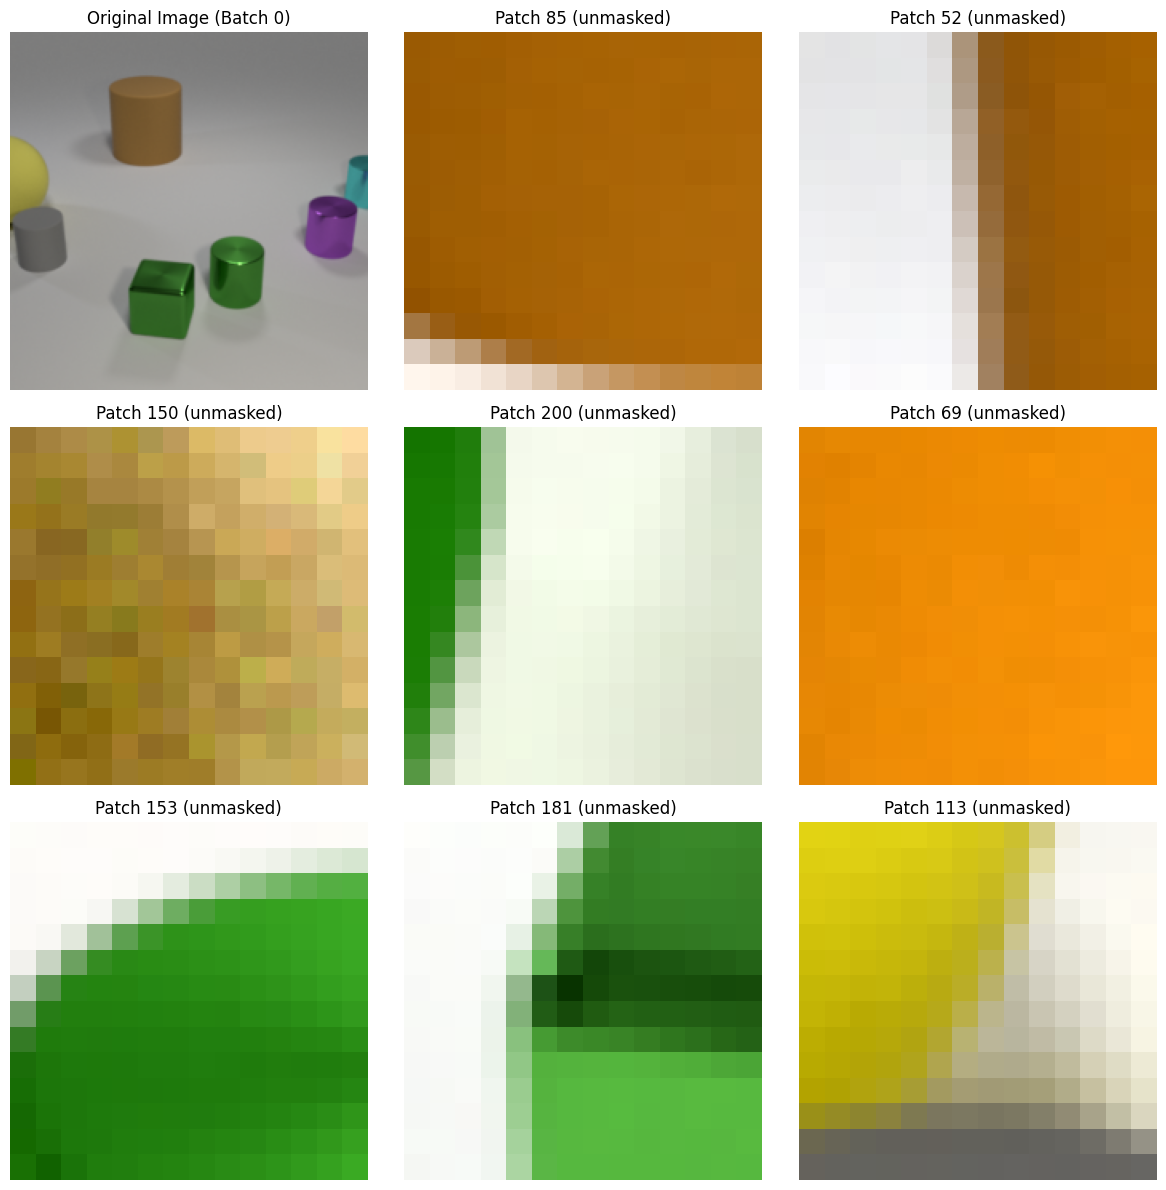

Total unmasked patches: 77
Showing 8 random unmasked patches


In [22]:
import random

# Get the first image from the batch as an example
batch_idx = 0

# Get unmasked patch indices (where mask is True/1)
unmasked_indices = torch.where(mask[batch_idx] == 1)[0]

# Select around 8 random unmasked patches (or fewer if not enough available)
num_patches_to_show = min(8, len(unmasked_indices))
selected_patch_indices = random.sample(unmasked_indices.tolist(), num_patches_to_show)

# Create visualization
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Show the original source image
original_image = images[batch_idx].permute(1, 2, 0).cpu()  # CHW -> HWC
# Denormalize if needed (assuming ImageNet normalization)
# mean = torch.tensor([0.485, 0.456, 0.406])
# std = torch.tensor([0.229, 0.224, 0.225])
# original_image = original_image * std + mean
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min() + 1e-8)

axes[0].imshow(original_image)
axes[0].set_title(f"Original Image (Batch {batch_idx})")
axes[0].axis('off')

# Show selected unmasked patches
for idx, patch_idx in enumerate(selected_patch_indices, start=1):
    patch = object_patches[batch_idx, patch_idx].permute(1, 2, 0).cpu()  # CHW -> HWC
    # Denormalize if needed
    # patch = patch * std + mean
    patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
    
    axes[idx].imshow(patch)
    axes[idx].set_title(f"Patch {patch_idx} (unmasked)")
    axes[idx].axis('off')

# Hide any unused subplots
for idx in range(num_patches_to_show + 1, 9):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"Total unmasked patches: {len(unmasked_indices)}")
print(f"Showing {num_patches_to_show} random unmasked patches")

In [31]:
dinov2_vits14.norm.normalized_shape[0]

384